https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset/data - выбранный датасет для рассмотрения


In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('user_behavior_dataset.csv') # записываем данные в датафрейм

print(df.head()) # выведем первые строки датасета, чтобы убедиться, что все хорошо

   User ID    Device Model Operating System  App Usage Time (min/day)  \
0        1  Google Pixel 5          Android                       393   
1        2       OnePlus 9          Android                       268   
2        3    Xiaomi Mi 11          Android                       154   
3        4  Google Pixel 5          Android                       239   
4        5       iPhone 12              iOS                       187   

   Screen On Time (hours/day)  Battery Drain (mAh/day)  \
0                         6.4                     1872   
1                         4.7                     1331   
2                         4.0                      761   
3                         4.8                     1676   
4                         4.3                     1367   

   Number of Apps Installed  Data Usage (MB/day)  Age  Gender  \
0                        67                 1122   40    Male   
1                        42                  944   47  Female   
2                

Уберем лишние столбцы в датасете, чтобы оставить только числовые значения к рассмотрению


In [4]:
input_data = df.drop(df.columns[[1, 2, 9]], axis=1)
print(input_data.head())

   User ID  App Usage Time (min/day)  Screen On Time (hours/day)  \
0        1                       393                         6.4   
1        2                       268                         4.7   
2        3                       154                         4.0   
3        4                       239                         4.8   
4        5                       187                         4.3   

   Battery Drain (mAh/day)  Number of Apps Installed  Data Usage (MB/day)  \
0                     1872                        67                 1122   
1                     1331                        42                  944   
2                      761                        32                  322   
3                     1676                        56                  871   
4                     1367                        58                  988   

   Age  User Behavior Class  
0   40                    4  
1   47                    3  
2   42                    2  
3   20  

In [9]:
# Сделаем бинарный столбец для того, чтобы понять баланс датасета. Используем столбец проведенного времени на экране, чтобы определить пользователей, пренебрегающих использованием гаджета
input_data['Addicted users'] = input_data['Screen On Time (hours/day)'].apply(lambda x: 1 if x > 4.5 else 0)  

X = input_data.drop(columns = ['Addicted users', 'Screen On Time (hours/day)'])
y = input_data['Addicted users']

# Разделим данные на тестовые и тренировочные.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

input_data['Addicted users'].value_counts()

Addicted users
1    377
0    323
Name: count, dtype: int64

Здесь видим, что наше распределение оказалось довольно сбалансированным, так как разделение между пользователями по созданному атрибуту довольно близко к 50 процентам.
Попробуем дополнительно немного поправить баланс.


In [10]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

In [11]:
knn = KNeighborsClassifier(n_neighbors=2)
dec_tree = DecisionTreeClassifier(random_state=42)

knn.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn.predict(X_test)

dec_tree.fit(X_train_smote, y_train_smote)
y_pred_tree_smote = dec_tree.predict(X_test)

print(classification_report(y_test, y_pred_knn_smote))
print(classification_report(y_test, y_pred_tree_smote))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        65
           1       0.97      0.85      0.91        75

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140

              precision    recall  f1-score   support

           0       0.92      0.91      0.91        65
           1       0.92      0.93      0.93        75

    accuracy                           0.92       140
   macro avg       0.92      0.92      0.92       140
weighted avg       0.92      0.92      0.92       140



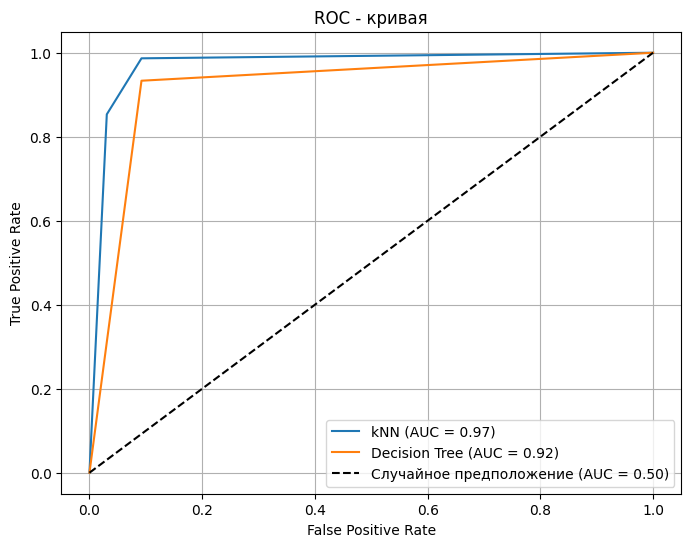

In [19]:
# Построим ROC-кривую.
from sklearn.metrics import roc_curve, auc

y_prob_knn = knn.predict_proba(X_test)[:, 1]
y_prob_tree = dec_tree.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"kNN (AUC = {roc_auc_knn:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Случайное предположение (AUC = 0.50)")
plt.title("ROC - кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Вывод: 
1. Класс 'Зависимые пользователи' (0)

<table>
<thead>
<tr><th>Model        </th><th style="text-align: right;">  Precision</th><th style="text-align: right;">  Recall</th><th style="text-align: right;">  F-score</th></tr>
</thead>
<tbody>
<tr><td>kNN          </td><td style="text-align: right;">       0.85</td><td style="text-align: right;">    0.97</td><td style="text-align: right;">     0.91</td></tr>
<tr><td>Decision Tree</td><td style="text-align: right;">       0.92</td><td style="text-align: right;">    0.91</td><td style="text-align: right;">     0.91</td></tr>
</tbody>
</table>

Метрика Precision в случае c не зависимыми от  гораздо меньше у knn, чем у дерева решений, но при этом Recall намного больше, а значения F-score показывают, что оба метода ведут себя крайне сбалансированно. В этом случае дерево решений чуть-чуть лучше себя проявляет чем kNN

2. Класс 'Зависимые пользователи' (1)

<table>
<thead>
<tr><th>Model        </th><th style="text-align: right;">  Precision</th><th style="text-align: right;">  Recall</th><th style="text-align: right;">  F-score</th></tr>
</thead>
<tbody>
<tr><td>kNN          </td><td style="text-align: right;">       0.97</td><td style="text-align: right;">    0.85</td><td style="text-align: right;">     0.91</td></tr>
<tr><td>Decision Tree</td><td style="text-align: right;">       0.92</td><td style="text-align: right;">    0.93</td><td style="text-align: right;">     0.93</td></tr>
</tbody>
</table>


В этом случае по метрике precision видим, что kNN куда точнее работает с данными, но уже в метрике recall дерево решений значительно обгоняет knn, а суммарно дерево решений куда лучше работает с зависимыми пользователями благодаря значению F-score. Здесь, как и в первом случае, дерево решений суммарно немного лучше определяет зависимых пользователей, чем kNN

3. Общий показатель: 
Метод kNN показывает менее высокую точность, нежели дерево решений (Accuracy: 0,91 против 0,92).

4. ROC: 
Несмотря на предыдущие пункты, по графику видим, что метод kNN имеет куда большую площадь, чем дерево решений, что показывает лучшее разделение классов.
Таким образом, оба метода показали себя отлично при работе с данными, при всем этом если нам надо получить больший охват данных, то будет наиболее подходящим для использования knn, если мы не хотим терять точности обработки данных, то следует взять метод дерева решений